<a href="https://colab.research.google.com/github/daanyal011/Potato-Disease-Classification/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection and preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install --upgrade tensorflow keras

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato disease classification/Training/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 2162 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names
#folder names are class names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset) # because element in the dataset is a batch of 32 images

68

In [9]:
68*32 # this is actual length beacuse each element is 32 batch

2176

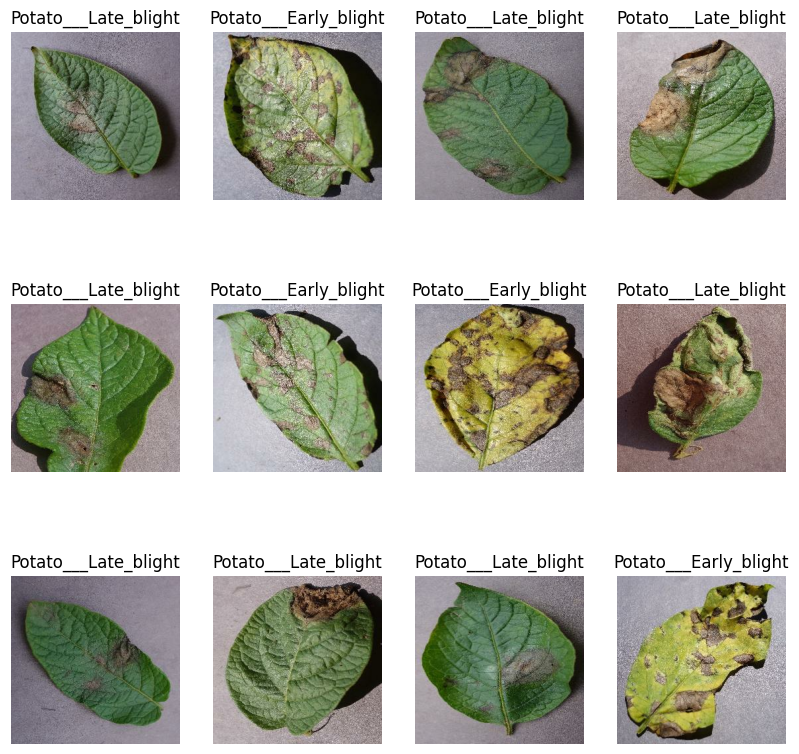

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off") #this will remove the axis

In [11]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = dataset.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(test_size)

    return train_ds, val_ds, test_ds


In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

6

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Building


In [25]:
#MODEL BUILDING
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [29]:
history = model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 19s 135ms/step - loss: 0.8971 - accuracy: 0.4745 - val_loss: 0.8802 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.6609 - accuracy: 0.6985 - val_loss: 0.6421 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 0.5213 - accuracy: 0.7824 - val_loss: 0.5103 - val_accuracy: 0.7604
Epoch 4/50
54/54 [==============================] - 3s 61ms/step - loss: 0.3761 - accuracy: 0.8472 - val_loss: 0.2382 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2562 - accuracy: 0.9034 - val_loss: 0.2534 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2041 - accuracy: 0.9207 - val_loss: 0.1923 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2435 - accuracy: 0.9109 - val_loss: 0.1827 - val_accuracy: 0.9427
Epoch 8/50


In [30]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 4s 29ms/step - loss: 0.0241 - accuracy: 1.0000


In [31]:
scores

[0.024099545553326607, 1.0]

In [32]:
history

In [33]:
len(history.history['accuracy'])

50

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

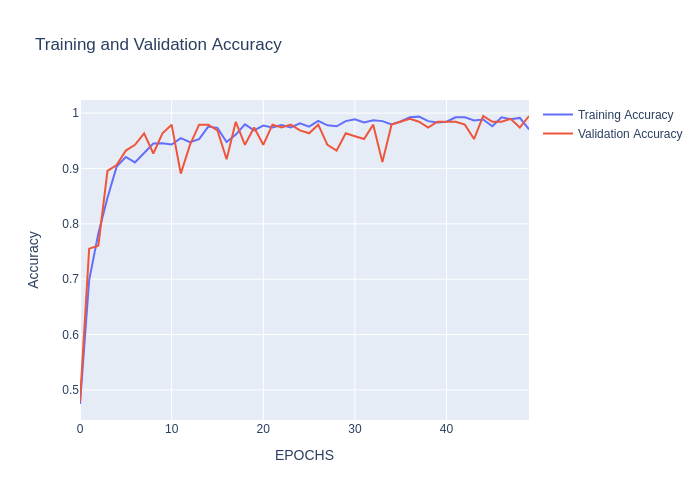

In [45]:
import plotly.graph_objs as go
import plotly.io as pio

# Create x and y data for the first line plot
x1 = tuple(range(EPOCHS))
y1 = acc

# Create x and y data for the second line plot
x2 = tuple(range(EPOCHS))
y2 = val_acc

# Create a single plot object
fig = go.Figure()

# Add the first line trace to the plot
fig.add_trace(go.Scatter(x=x1, y=y1, mode='lines', name='Training Accuracy'))

# Add the second line trace to the plot
fig.add_trace(go.Scatter(x=x2, y=y2, mode='lines', name='Validation Accuracy'))

# Update the plot layout
fig.update_layout(title='Training and Validation Accuracy', xaxis_title='EPOCHS', yaxis_title='Accuracy')

# Save the plot as a PNG image
pio.write_image(fig, 'graph.png')

fig.show("png")


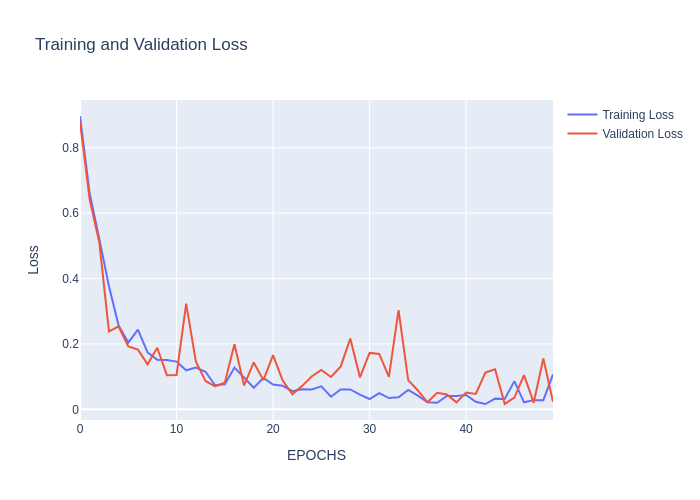

In [37]:
import plotly.graph_objs as go

# Create x and y data for first line plot
x1 = tuple(range(EPOCHS))
y1 = loss

# Create x and y data for second line plot
x2 = tuple(range(EPOCHS))
y2 = val_loss

# Create a single plot object
fig = go.Figure()

# Add the first line trace to the plot
fig.add_trace(go.Scatter(x=x1, y=y1, mode='lines', name='Training Loss'))

# Add the second line trace to the plot
fig.add_trace(go.Scatter(x=x2, y=y2, mode='lines', name='Validation Loss'))

# Update the plot layout
fig.update_layout(title='Training and Validation Loss', xaxis_title='EPOCHS', yaxis_title='Loss')

# Show the plot
fig.show("png")

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 292ms/step
predicted label: Potato___Early_blight


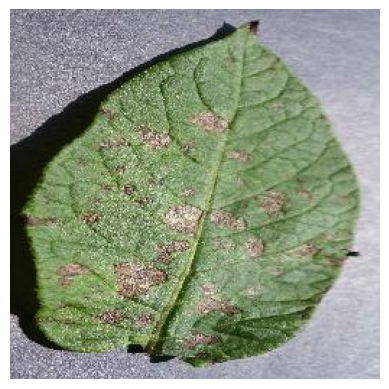

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8') # this will print the first image
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  plt.axis("off") # this will remove the axis
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


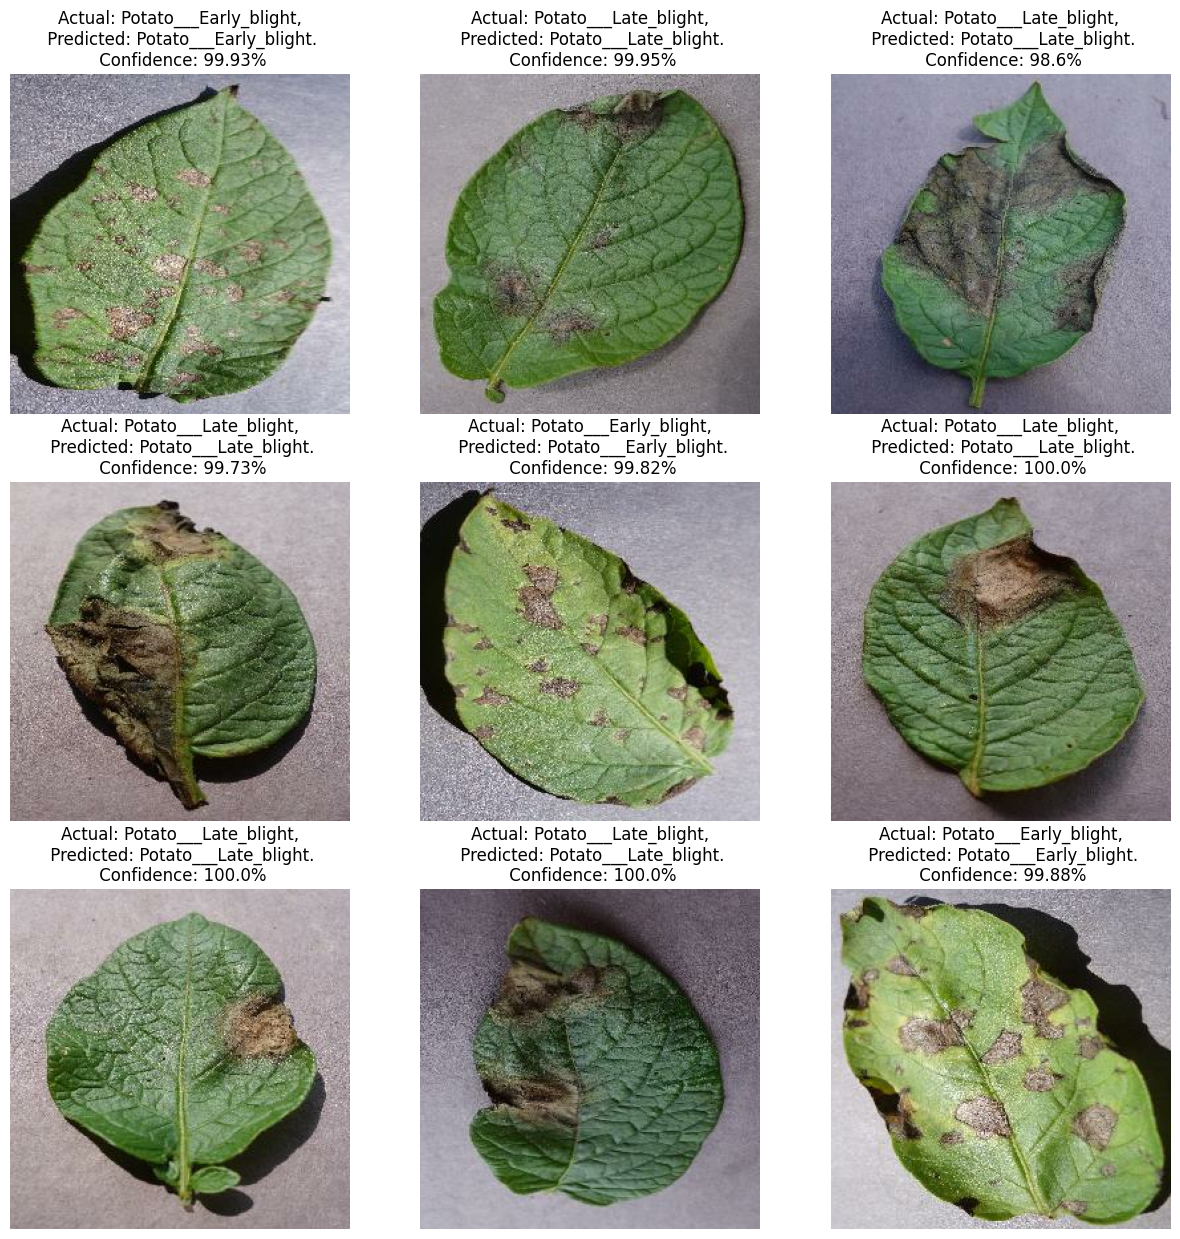

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [41]:
# import os
# model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Potato disease classification/Training/Model") + [0]])+1
# model.save(f"/content/drive/MyDrive/Potato disease classification/Training/Model/{model_version}")

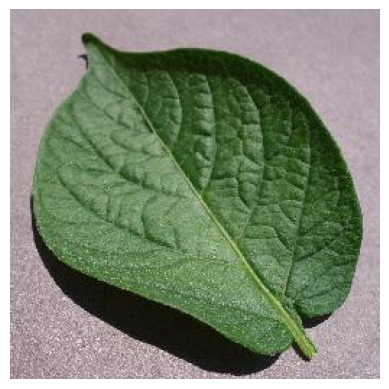

In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
img_path = '/content/0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817.JPG'
img = keras.preprocessing.image.load_img(
    img_path, target_size=(256, 256)
)
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

plt.imshow(img)
plt.axis('off')
plt.show()

# plt.show('/content/early-blight.png')

In [47]:
pred1 = model.predict(img_arr)
pred1

1/1 [==============================] - 0s 21ms/step


array([[8.6228539e-07, 1.4815078e-04, 9.9985099e-01]], dtype=float32)

In [48]:
# predicted_label_index = pred1.argmax()
print("predicted label:", class_names[np.argmax(pred1)])

predicted label: Potato___healthy
